## Initialising model and libraries

In [1]:

import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D
from fit.utils.utils import denormalize, denormalize_amp, denormalize_phi

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.transformers.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch
import numpy as np
import pandas as pd
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import scipy
seed_everything(22122020)
dm = MNIST_SResFITDM(root_dir='./datamodules/data/', batch_size=32,subset_flag = False)
dm.prepare_data()
dm.setup()
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='prod',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query,num_shells =5,
                              model_type = 'fast')

fig = plt.figure()
psnr_dict = {}
trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/Fast_prod__L_8_H_8_s_5_subset_False_27-03_16-58-36/epoch=222-step=383337.ckpt'
# trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/Fast_prod__L_8_H_8_s_5_subset_False_26-03_20-10-16/epoch=183-step=316296.ckpt'
# trained_model_path = '/home/aman.kukde/Projects/FourierImageTransformer/models/Fast_sum__L_8_H_8_s_5_subset_False_27-03_19-06-54/epoch=261-step=450378.ckpt'
weights = torch.load(trained_model_path)['state_dict']
model.load_state_dict(weights)
model.cuda()
model.eval()

trainer = Trainer(max_epochs=100, 
                #gpus=1, # set to 0 if you want to run on CPU
                callbacks=ModelCheckpoint(
                                            dirpath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Validation/avg_val_loss',
                                            mode='min'
                                        ), 
                deterministic=True)



/localscratch/miniforge3/envs/FIT_LS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 22122020


Using Full MNIST dataset


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<Figure size 640x480 with 0 Axes>

### Loading DataModule and predicting using inference and forward function both

In [31]:
model.input_seq_length

39

In [32]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
    break

fc = fc.to('cuda')
mag_min = mag_min.to('cuda')
mag_max = mag_max.to('cuda')
low_res = fc[:, flatten_order][:, :model.input_seq_length]
x_fc = fc[:, flatten_order][:, :-1]
y_fc = fc[:, flatten_order][:, 1:]
gt = fc[:, flatten_order]
print(low_res.shape)
with torch.no_grad():
    pred = model.sres.forward_inference(low_res,causal = True)
    # pred_forward = model.sres.forward(x_fc)


# print(f"training loss: {model.criterion(pred_forward,y_fc,mag_min,mag_max)}")



torch.Size([32, 39, 2])
torch.Size([378, 2])


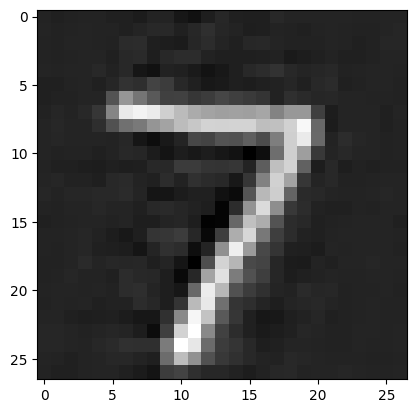

In [33]:
pred_img = model.convert2img(pred,mag_min,mag_max)
plt.imshow(pred_img[0].cpu().numpy(),cmap = 'gray')

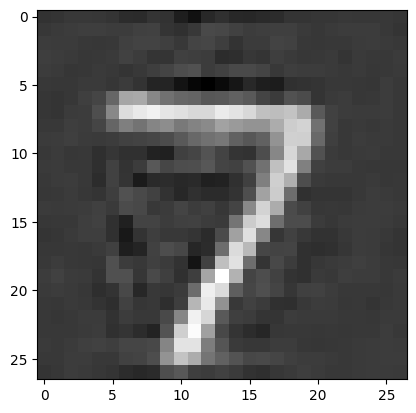

In [29]:
pred_img = model.convert2img(pred,mag_min,mag_max)
plt.imshow(pred_img[0].cpu().numpy(),cmap = 'gray')

### In Prediction Per Token Absolute Deviation from Ground Truth

In [24]:
a1 = (pred[0]-gt[0])[:,0][:]/(gt[0][:,0][:])
a2 = (pred_2[0]-gt[0])[:,0][:]/(gt[0][:,0][:])
a1 = a1.detach().cpu().numpy()
a2 = a2.detach().cpu().numpy()
b1 = (pred[0]-gt[0])[:,1][:]
b2 = (pred_2[0]-gt[0])[:,1][:]
b1 = b1.detach().cpu().numpy()
b2 = b2.detach().cpu().numpy()
plt.figure()
plt.plot([i for i in range(39,150)],a1[39:150],label = 'model_1_delta_amplitude')
plt.plot([i for i in range(39,150)],a2[39:150],label = 'model_2_delta_amplitude')
plt.legend();plt.show()
plt.figure()
plt.plot([i for i in range(39,150)],b1[39:150],label = 'model_1_delta_phi')
plt.plot([i for i in range(39,150)],b2[39:150],label = 'model_2_delta_phi')
plt.legend();plt.show()
plt.figure()
# plt.plot([x for x in range(39,len(a1))],(a1-a2)[39:],label = 'amplitude_diff')
plt.plot([x for x in range(39,150)],(b1-b2)[39:150],label = 'phi_diff')
plt.legend()
plt.show()



NameError: name 'pred_2' is not defined

### Masked

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


torch.Size([378, 2])


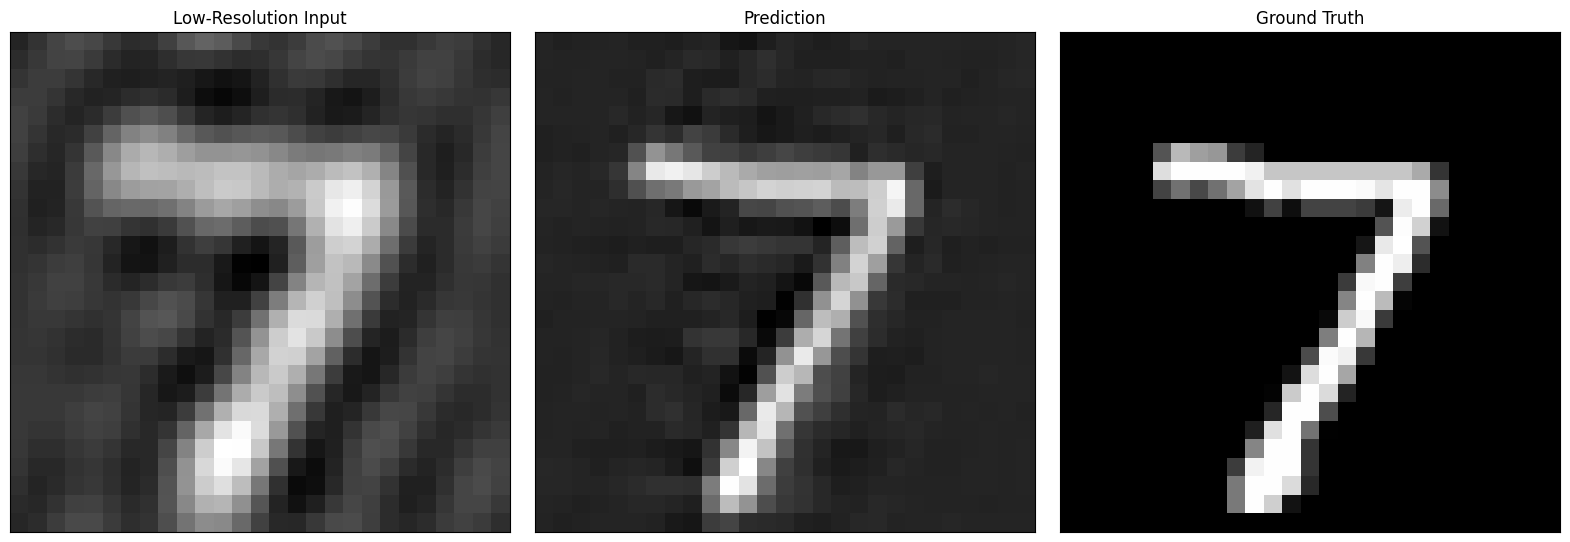

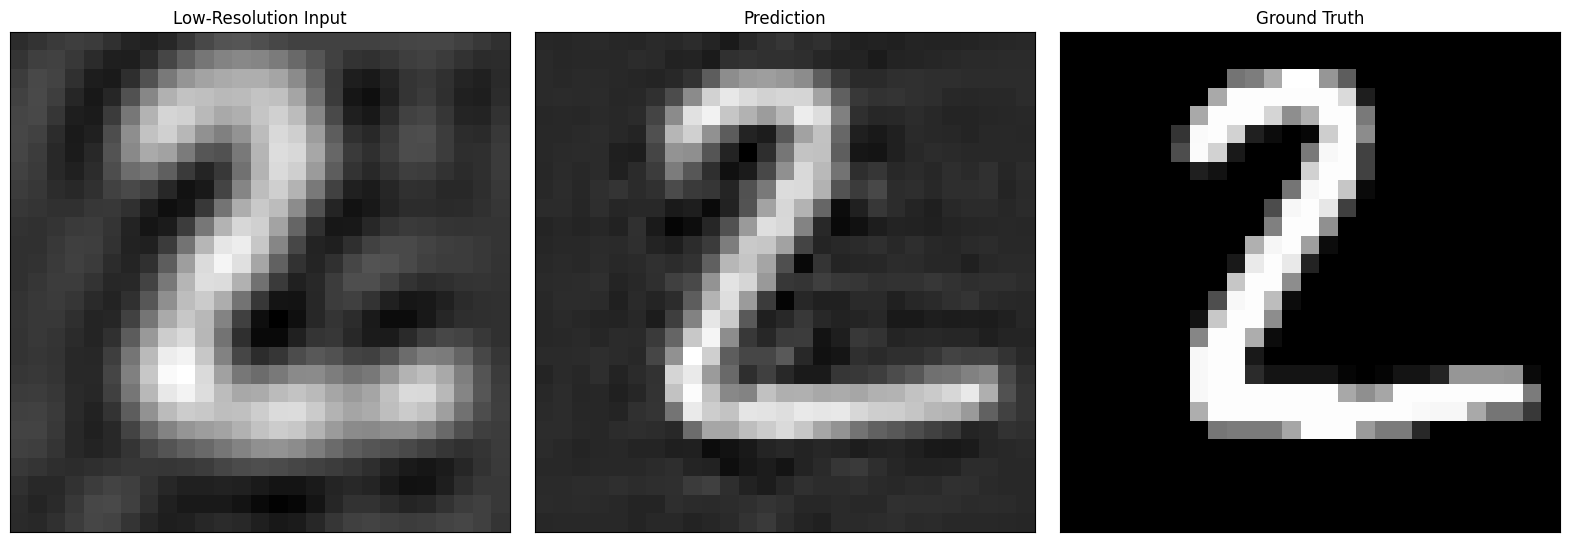

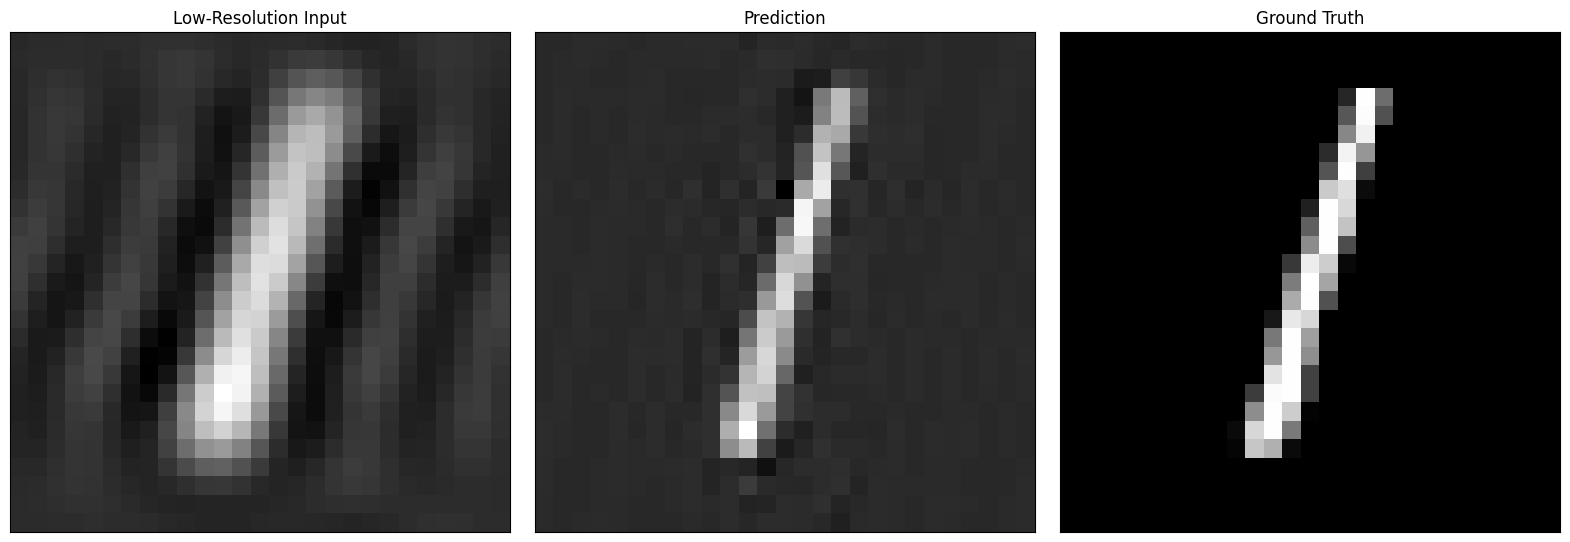

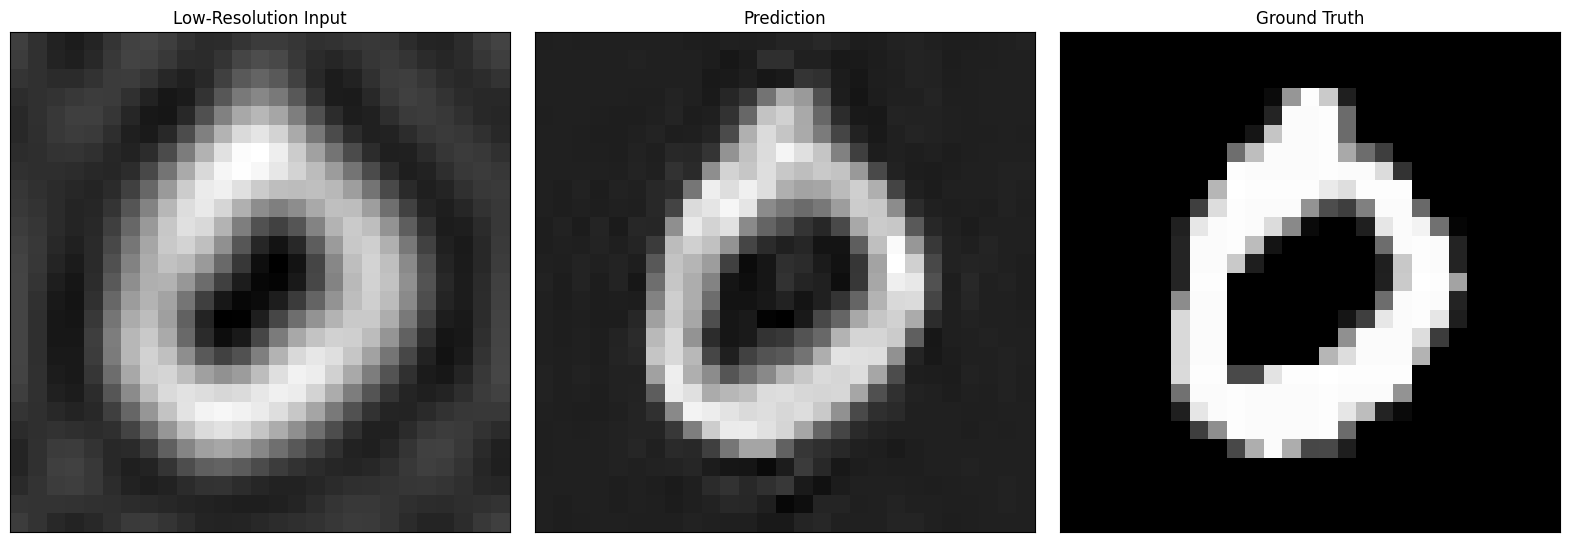

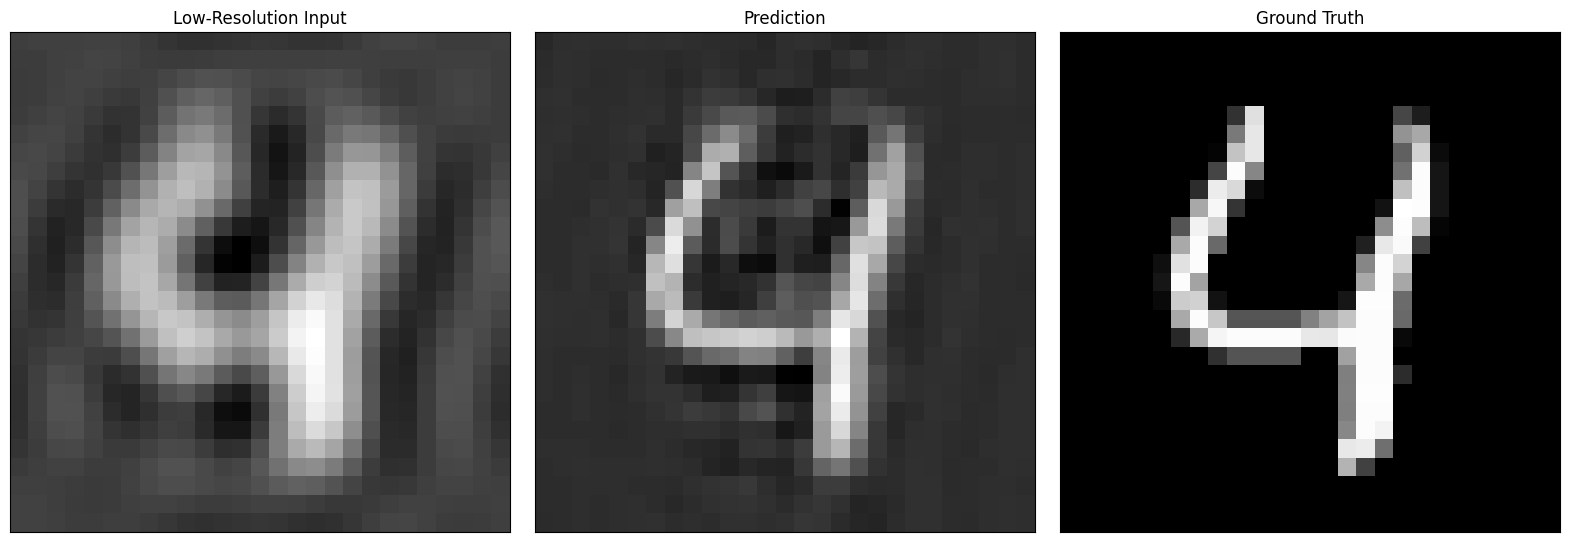

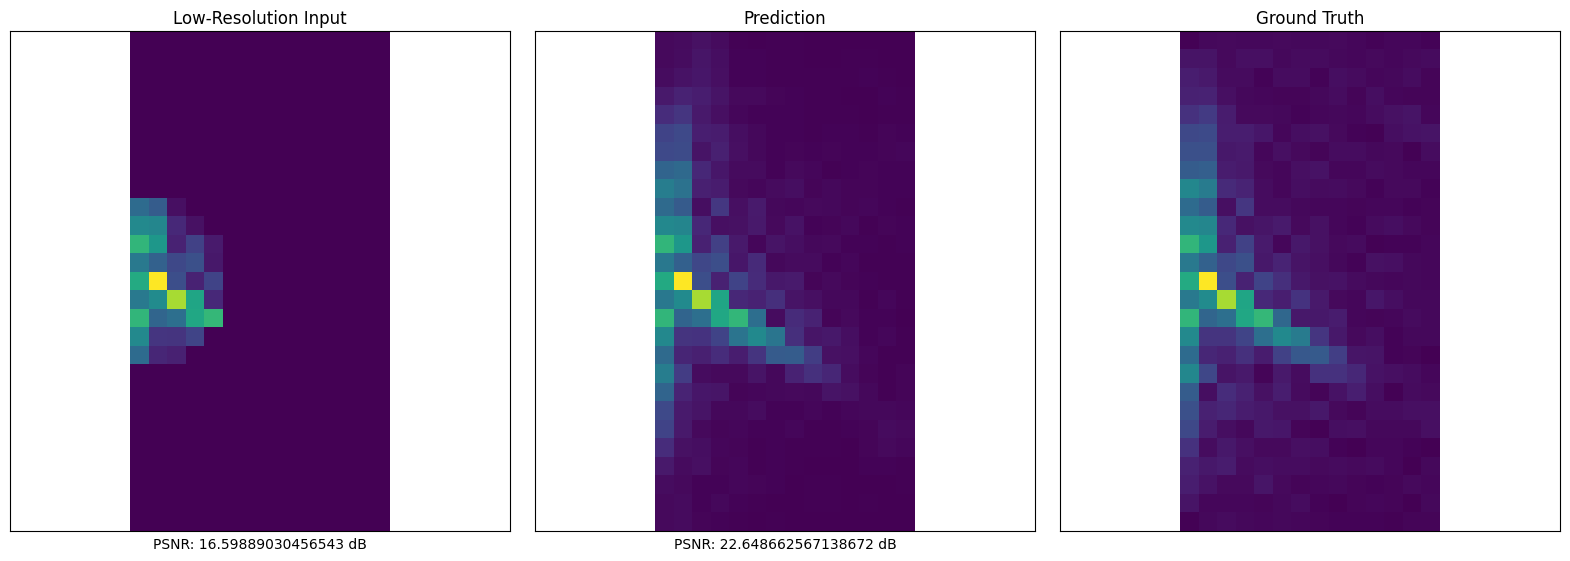

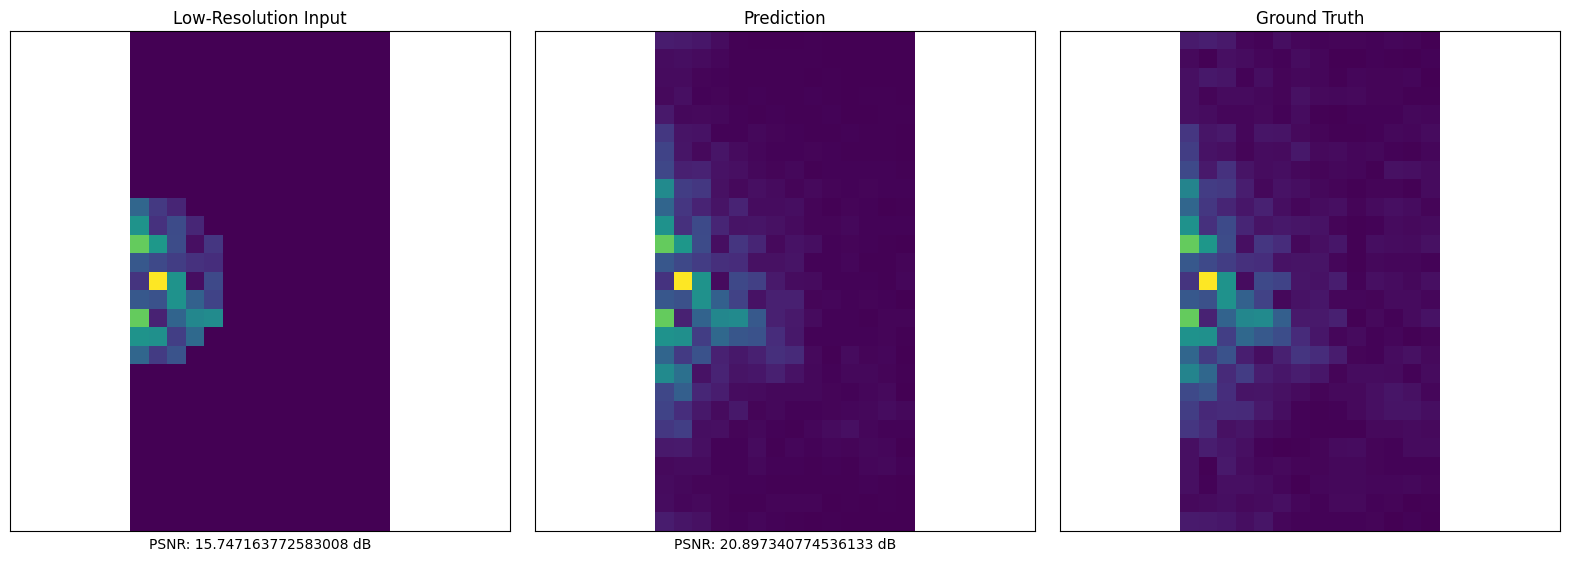

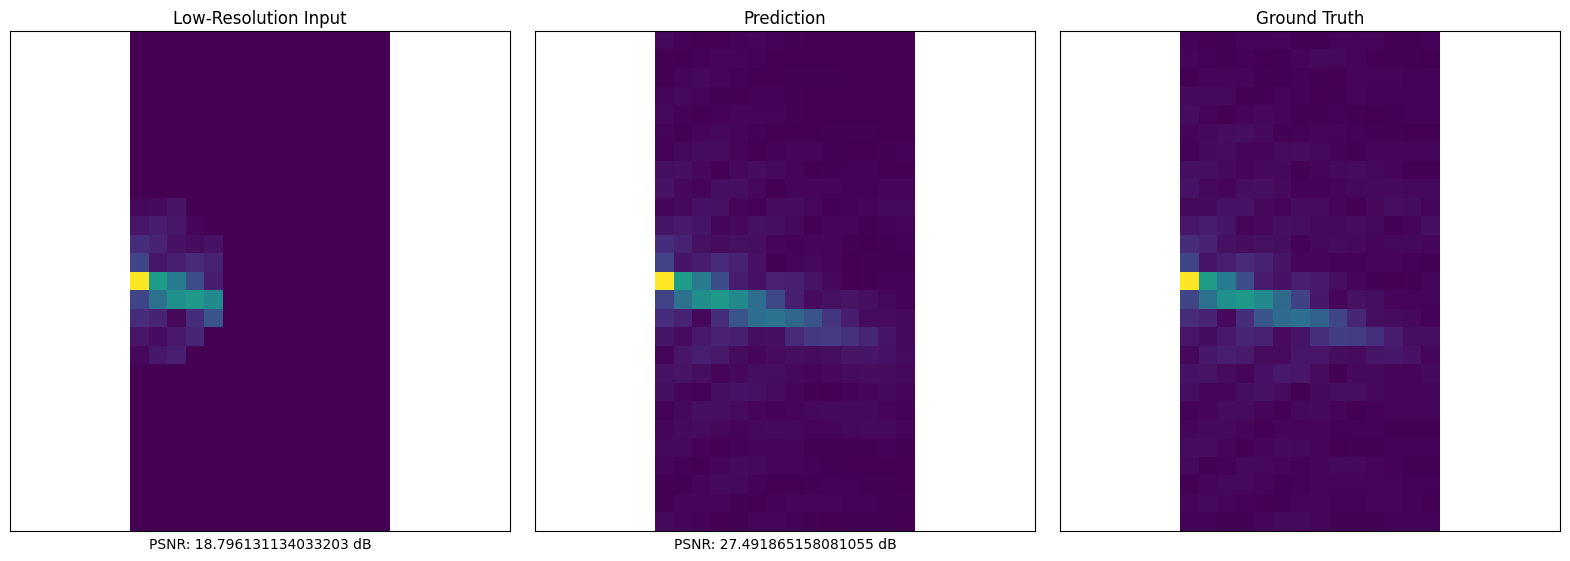

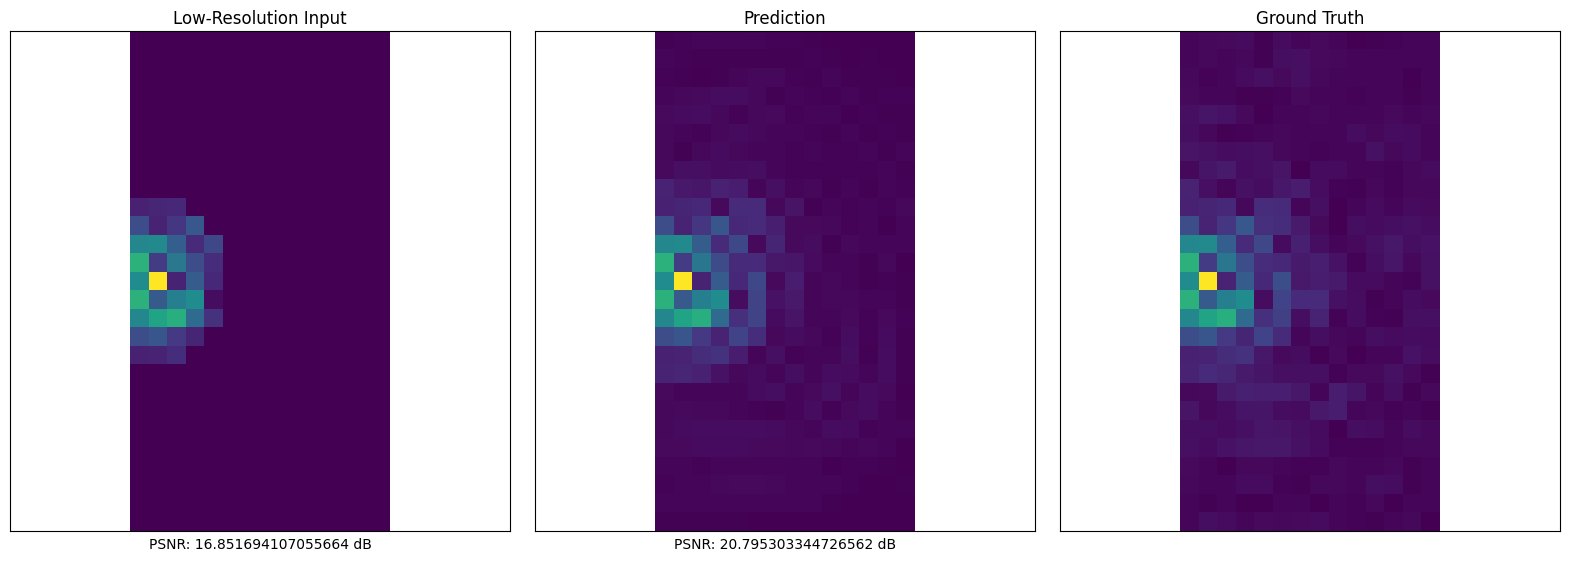

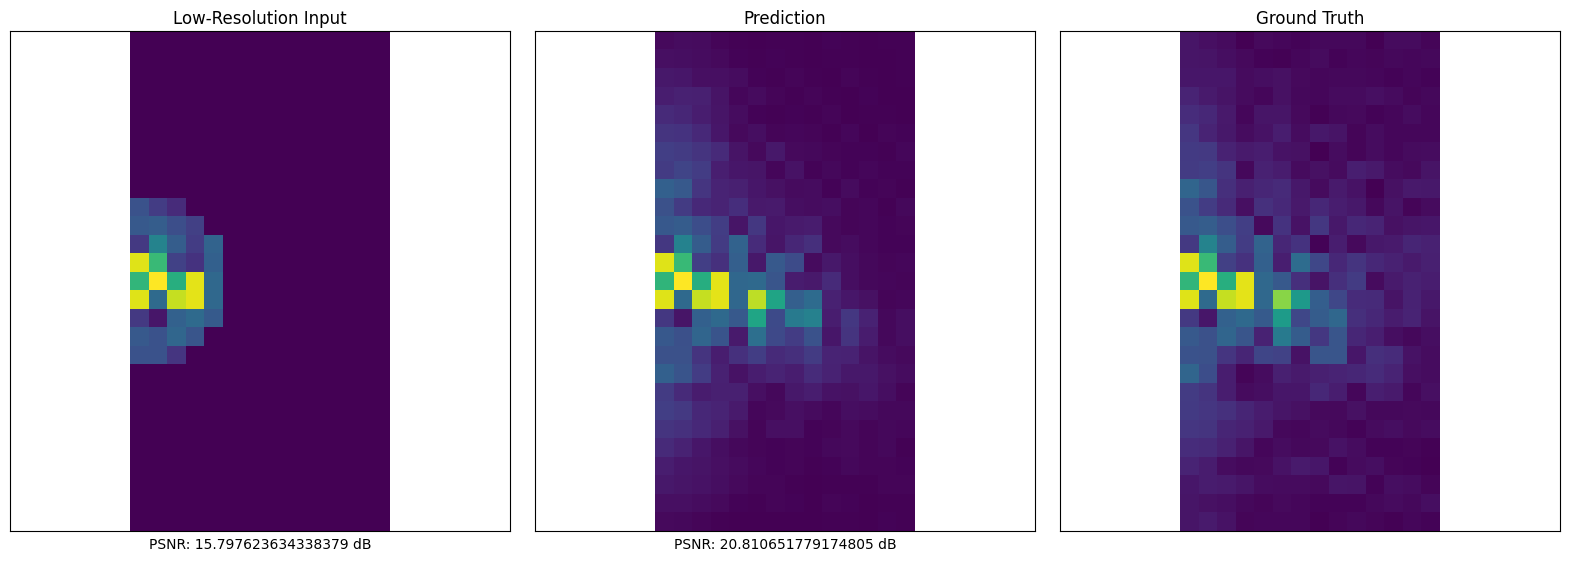

In [8]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
    break

fc = fc.to('cuda')
mag_min = mag_min.to('cuda')
mag_max = mag_max.to('cuda')
low_res = fc[:, flatten_order][:, :model.input_seq_length]

with torch.no_grad():
    pred = model.sres.forward_inference(low_res)

lowres = torch.zeros_like(pred)
lowres+=fc.min()
lowres[:, :model.input_seq_length] = fc[:, model.dst_flatten_order][:, :model.input_seq_length]
pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)     
lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)


lowres_psnr = PSNR(gt_img,lowres_img)
pred_psnr = PSNR(gt_img,pred_img)


sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True )
fig.legend()
plt.savefig('psnr_diff.png')
plt.close()
for i in [pred_img, lowres_img, gt_img]:
    i.cpu().detach().numpy()
for sample in range(5):
    fig2 = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
    ax0.set_title('Low-Resolution Input');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(pred_img[sample].cpu(), cmap='gray')
    ax1.set_title('Prediction');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt_img[sample].cpu(), cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.axis('equal');

from sklearn.random_projection import sample_without_replacement


diff = []
for i in range(5):
    sample = i
    # pred_img[i] = (pred_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    # lowres_img[i] = (lowres_img[i] - gt_img[i].min())/(gt_img[i].max() - gt_img[i].min())
    fig = plt.figure(figsize=(31/2., 10/2.))
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)
    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    lowres_psnr = PSNR(gt_img, lowres_img)
    # lowres_img_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], lowres_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax0.imshow(np.roll(abs(torch.fft.rfftn(lowres_img[sample].cpu(),dim = [0,1])),13,0))
    ax0.set_title('Low-Resolution Input');
    ax0.set_xlabel(f'PSNR: {lowres_psnr[sample].cpu().detach()} dB')
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(np.roll(abs(torch.fft.rfftn(pred_img[sample].cpu(),dim = [0,1])),13,0))
    pred_psnr = PSNR(gt_img, pred_img)
    # pred_vs_gt_img_psnr = PSNR(gt_img[sample].cpu()[2:, 2:], pred_img[sample].cpu()[2:, 2:], drange=torch.tensor(255., dtype=torch.float32))
    ax1.set_title('Prediction');
    ax1.set_xlabel(f'PSNR: {pred_psnr[sample].cpu().detach()} dB')
    ax1.axis('equal');

    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(np.roll(abs(torch.fft.rfftn(gt_img[sample].cpu(),dim = [0,1])),13,0))
    ax2.set_title('Ground Truth');
    # ax2.set_xlabel(f'Max: {gt_img[sample].cpu().max():.2f} Min: {gt_img[sample].cpu().min():.2f}');
    ax2.axis('equal');
    diff.append(lowres_psnr - pred_psnr)
    

In [39]:
# import sys
# sys.path.append("../")

# import torch
# import wandb
# import ssl
# import datetime
import matplotlib
from tqdm.notebook import tqdm

# from fit.utils.tomo_utils import get_polar_rfft_coords_2D
# from fit.modules.SResTransformerModule import SResTransformerModule
# from fit.datamodules.super_res.SResDataModule import MNIST_SResFITDM, CelebA_SResFITDM

# from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning import Trainer, seed_everything
# from pytorch_lightning.callbacks import ModelCheckpoint

# import matplotlib.pyplot as plt
# import seaborn as sns

# from fit.transformers.PSNR import RangeInvariantPsnr as PSNR

# ssl._create_default_https_context = ssl._create_unverified_context
# torch.set_float32_matmul_precision("medium")
# seed_everything(22122020)

# # if __name__ == "__main__":
# import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument("--causal_mask", action="store_true", help="Use causal mask", default=True)
# parser.add_argument("--d_query", type=int, help="d_query", default=32)
# parser.add_argument("--model_type", type=str, help="Model to be used in the transformer (torch or fast)", default="fast")
# parser.add_argument("--n_layers", type=int, help="Number of layers in the transformer", default=8)
# parser.add_argument("--n_heads", type=int, help="No of heads in the transformer", default=8)
# parser.add_argument("--n_shells",type=int,help="Number of shells used as lowres-input in the transformer",default=5)
# parser.add_argument("--models_save_path", type=str, default="/home/aman.kukde/Projects/FourierImageTransformer/models/")
# parser.add_argument("--model_name", type=str, default= 'Fast_prod__L_8_H_8_s_5_subset_False_27-03_16-58-36/epoch=222-step=383337.ckpt')

# args = parser.parse_args()

# n_layers = args.n_layers
# n_shells = args.n_shells
# n_heads = args.n_heads
# model_type = args.model_type
# models_save_path = args.models_save_path
# model_name = args.model_name
# causal_mask = args.causal_mask
# d_query = args.d_query

# dm = MNIST_SResFITDM(root_dir="./datamodules/data/", batch_size=32)
# dm.prepare_data()
# dm.setup()

# r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)

# model = SResTransformerModule(
#     n_heads=n_heads,
#     d_query=d_query,
#     img_shape=dm.gt_shape,
#     coords=(r, phi),
#     model_type=model_type,
#     dst_flatten_order=flatten_order,
#     dst_order=order,
#     weight_decay=0.01,
#     n_layers=n_layers,
#     num_shells=n_shells,
# )
# print(f"\n\n\n\n{model}\n\n\n\n")
# weights = torch.load(models_save_path + model_name)['state_dict']
# model.load_state_dict(weights)
# print(f"Model loaded successfully {model_name}")

# trainer = Trainer(max_epochs=100, 
#                 callbacks=ModelCheckpoint(
#                                             dirpath=None,
#                                             save_top_k=1,
#                                             verbose=False,
#                                             save_last=True,
#                                             monitor='Validation/avg_val_loss',
#                                             mode='min'
#                                         ), 
#                 deterministic=True)

model.cuda()

def make_figs(lowres_psnr, pred_psnr):
    font = {'family' : 'serif',
        'weight': 'normal',
        'size'   : 16}
    matplotlib.rc('font', **font)
    
    fig = plt.figure(figsize = (12,9))
    sns.histplot(lowres_psnr.cpu().detach(), kde=True, color='blue',legend =True,label = "lowres")
    sns.histplot(pred_psnr.cpu().detach(), kde=True, color='red', legend= True, label = "pred")
    fig.legend()
    plt.savefig('../inference_results/psnr_hist.png')
    plt.close()

    fig = plt.figure(figsize = (12,9))
    sns.histplot(pred_psnr.cpu().detach() - lowres_psnr.cpu().detach(), kde=True, color='green', legend= True, label = "diff")
    fig.legend()
    plt.savefig('../inference_results/psnr_diff.png')
    plt.close()

    plt.figure(figsize = (12,9));
    plt.boxplot([lowres_psnr,pred_psnr,pred_psnr - lowres_psnr],widths = [0.9]*3,labels = ['lowres_psnr','pred_psnr', 'diff (pred - lowres)']);
    plt.savefig('../inference_results/psnr_box_LvsPvsD.png');
    plt.close()

    plt.figure(figsize = (12,9));
    plt.boxplot([lowres_psnr,pred_psnr],widths = [0.9]*2,labels = ['lowres_psnr','pred_psnr']);
    plt.savefig('../inference_results/psnr_box_LvsP.png');
    plt.close()

    plt.figure(figsize = (12,9));
    plt.boxplot([pred_psnr - lowres_psnr],widths = [0.9],labels = ['diff (pred - lowres)']);
    plt.savefig('../inference_results/psnr_box_diff.png');
    plt.close()

    diff = np.sort(pred - lowres)
    p = np.arange(0, 101, 1)
    xt = np.arange(0, 105, 5)
    perc = np.percentile(diff, q=p)
    plt.figure(figsize=(10,10))
    plt.plot(diff, label='PSNR Difference Prediction - Lowres')
    plt.plot((len(diff)+1) * p/100., perc, 'ro',label = '+1 Percentile of PSNR Difference Distribution')

    plt.xticks((len(diff)-1) * xt/100., map(str, xt))
    plt.legend()
    plt.grid()
    plt.savefig('../inference_results/psnr_diff_percentile.png')
    
    return None
lowres_psnr = []
pred_psnr = []


def get_lowres_pred_gt_img(fc, pred, mag_min, mag_max):
    lowres = torch.zeros_like(pred)
    lowres += fc.min()
    lowres[:, :model.input_seq_length] = fc[:, model.dst_flatten_order][:, :model.input_seq_length]
    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)     
    lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=fc[:, model.dst_flatten_order], mag_min=mag_min, mag_max=mag_max)
    return pred_img,lowres_img,gt_img











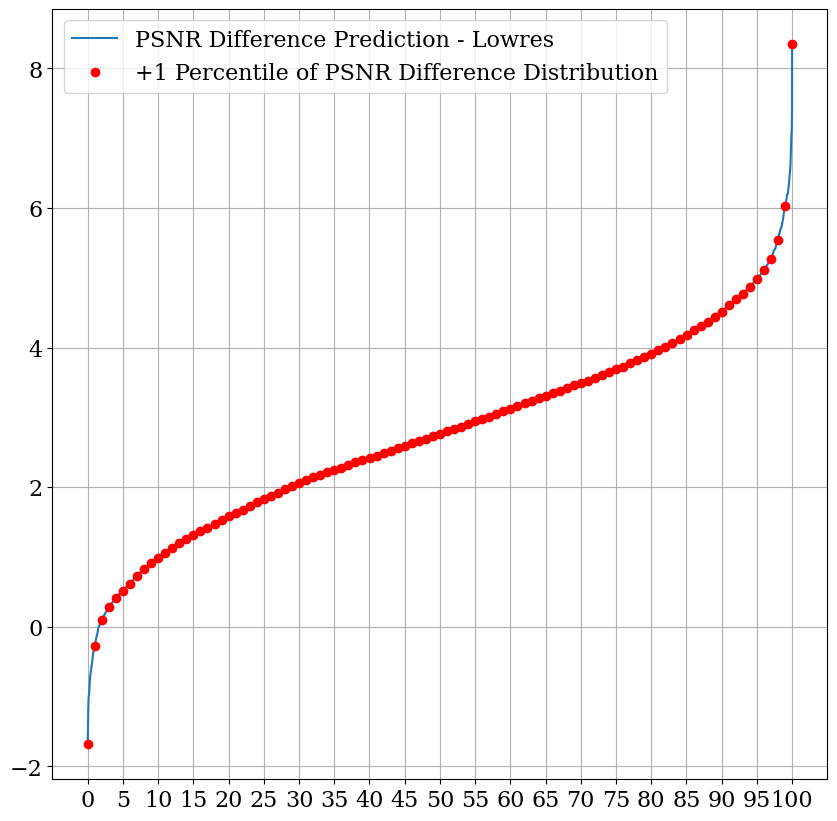

In [40]:
lowres = torch.load('../inference_results/lowres.pt').cpu()
pred = torch.load('../inference_results/pred.pt').cpu()
make_figs(low_res,pred)